In [326]:
import importlib
import pipeline as pp
import stats_hc as hc
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np

In [327]:
tab20 = plt.get_cmap('tab20').colors
hex_colors = ['#' + ''.join(f'{int(c*255):02x}' for c in color) for color in tab20]
print(hex_colors)

['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']


In [328]:
# Define the types
types = [
    'fake',
    'conspiracy',
    'junksci',
    'hate',
    'unreliable',
    'bias',
    'satire',
    'reliable',
    'clickbait',
    'political',
]
# Assign colors to each type from the Tab20 color map
colors = plt.get_cmap('tab10').colors[:len(types)]
# Add black color for unknown types
unknown_types = set(types)  # get all other unknown types
colors += tuple(['black'] * len(unknown_types))  # add black color for other unknown types
# Create a dictionary mapping each type to its assigned color
types_colors = {types[i]: colors[i] for i in range(len(types))}

types_liar = [
    'pants-fire',
    'false',
    'mostly-false',
    'barely-true',
    'half-true',
    'mostly-true',
    'true',
]
# Assign colors to each type from the Tab20 color map
colors = plt.get_cmap('tab10').colors[:len(types_liar)]
# Add black color for unknown types
unknown_types = set(types_liar)  # get all other unknown types
colors += tuple(['black'] * len(unknown_types))  # add black color for other unknown types
# Create a dictionary mapping each type to its assigned color
types_liar_colors = {types_liar[i]: colors[i] for i in range(len(types_liar))}

In [329]:
importlib.reload(hc)
liar_set = True
if liar_set:
    data = pd.read_csv("../datasets/liar_dataset/cleaned/combined_cleaned.csv")
    Stat = hc.Statistics(data=data, content_label="statement_cleaned", type_label="label", binary_type_label='label_binary', type_colors=types_liar_colors, sentence_analysis_label="sentence_analysis", party_label="party", speaker_label="speaker", subjects_label="subjects")
else:
    data = pd.read_csv("../datasets/sample/cols_and_rows_removed_combined.csv")
    Stat = hc.Statistics(data=data, content_label="content_cleaned", type_label="type", binary_type_label='type_binary', domain_label='domain', type_colors=types_colors, sentence_analysis_label="sentence_no_swords_analysis")

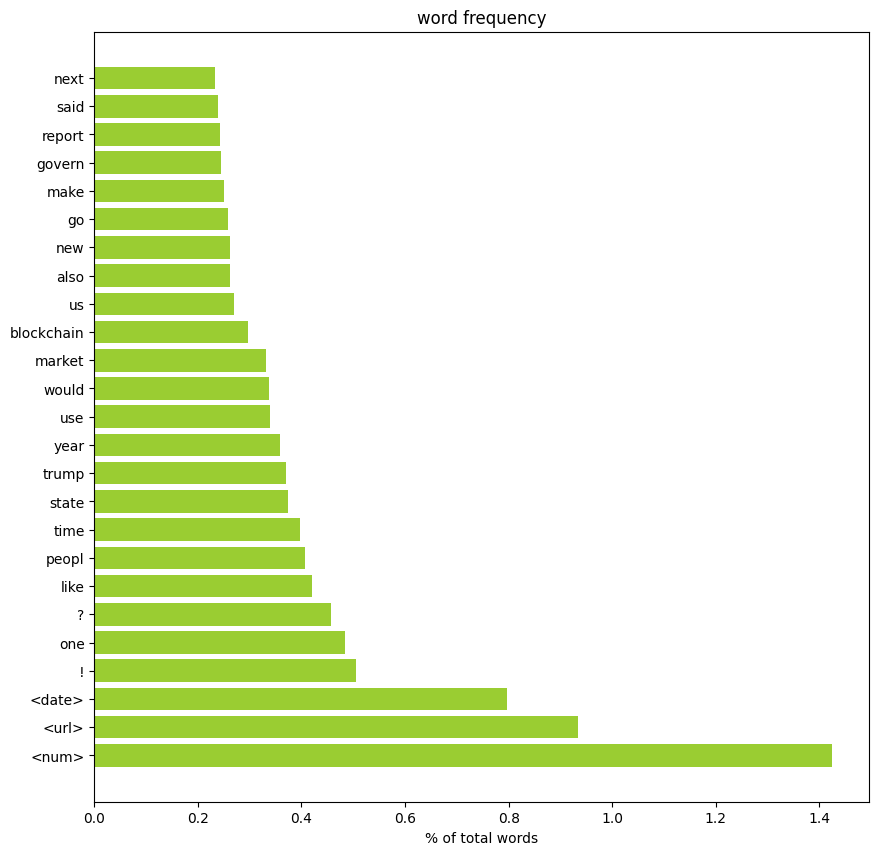

In [330]:
Stat.barplot_word_frequency()

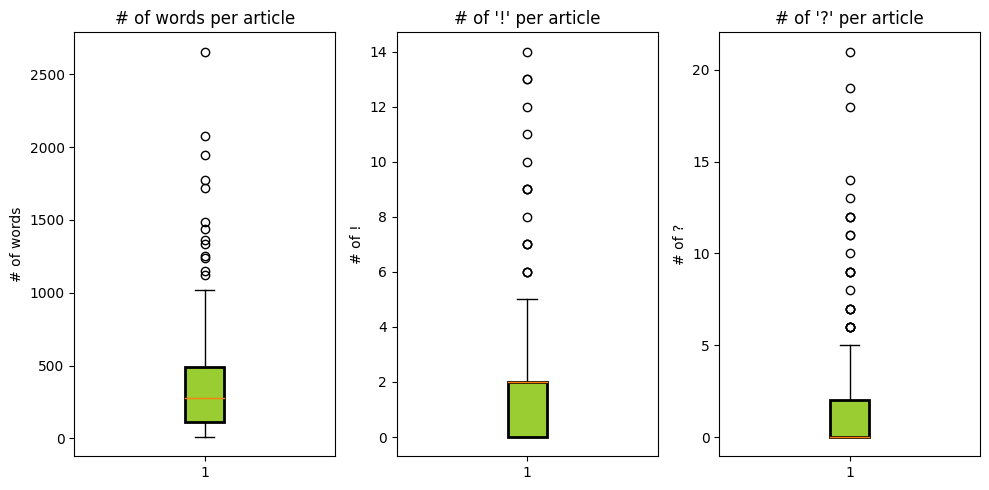

In [331]:
Stat.boxplot_word_frequency()
#TODO: TRUE FAKE

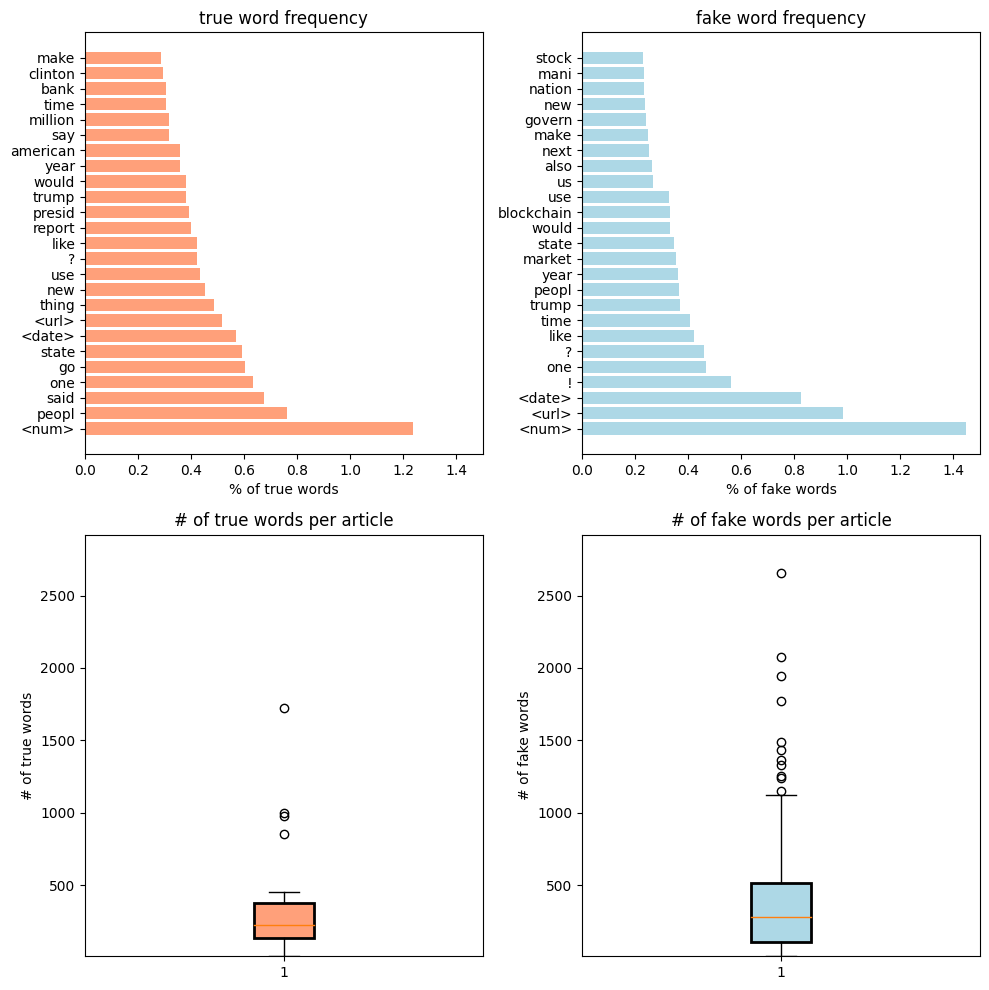

In [332]:
Stat.plot_word_frequency_fake_vs_true()

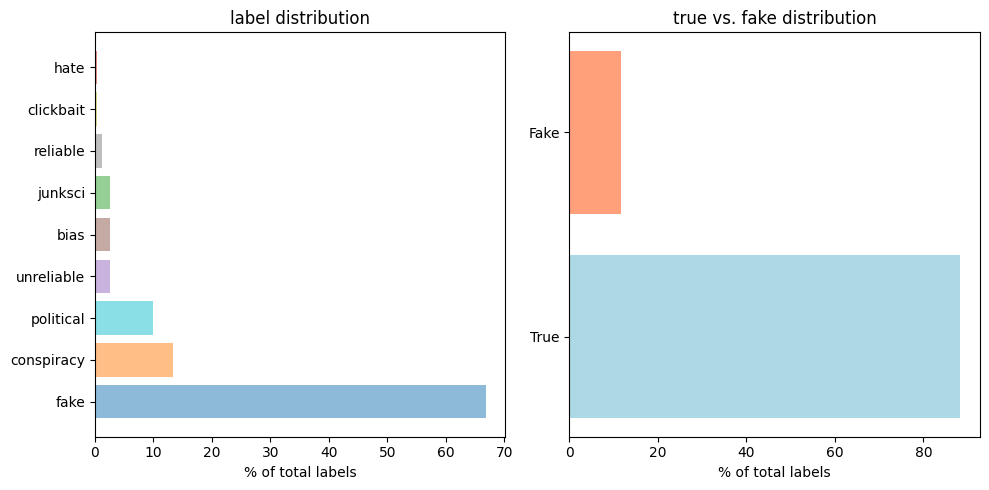

In [333]:
Stat.plot_type_fake_vs_true()

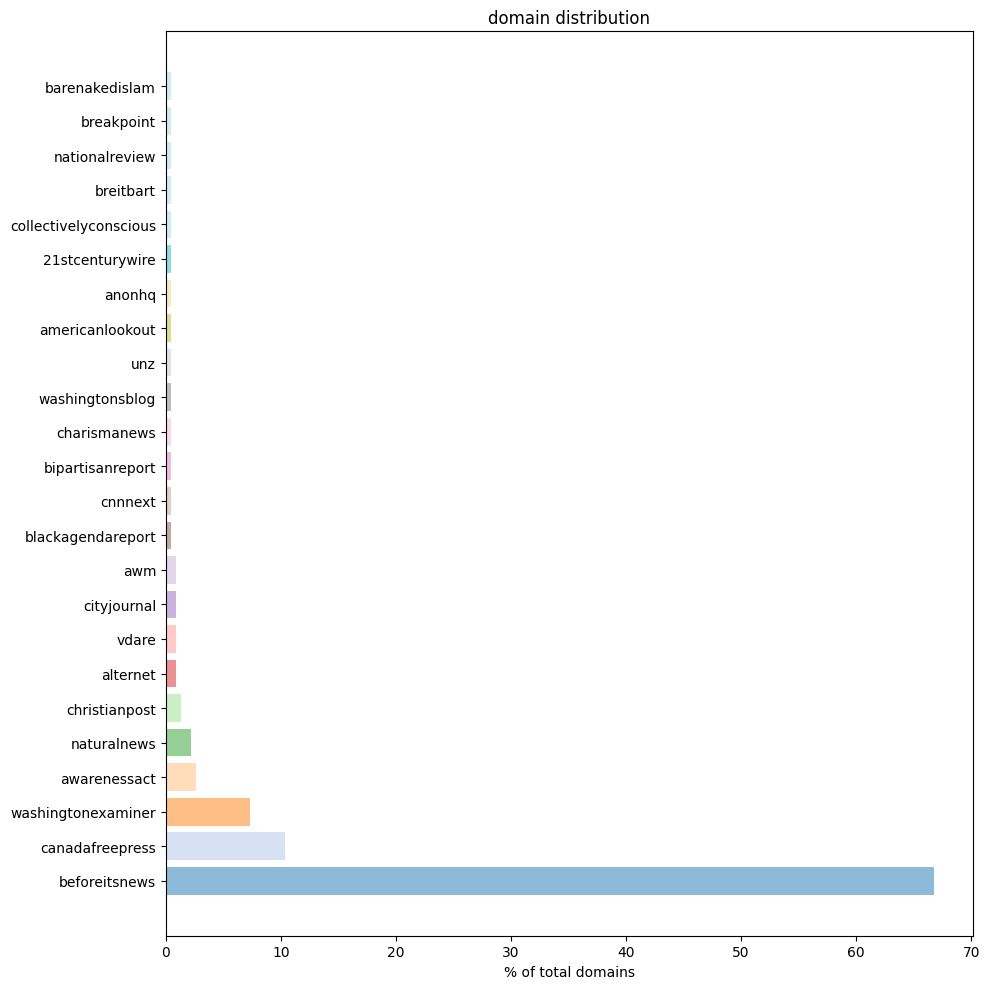

In [334]:
if not liar_set:
    Stat.barplot_domain()

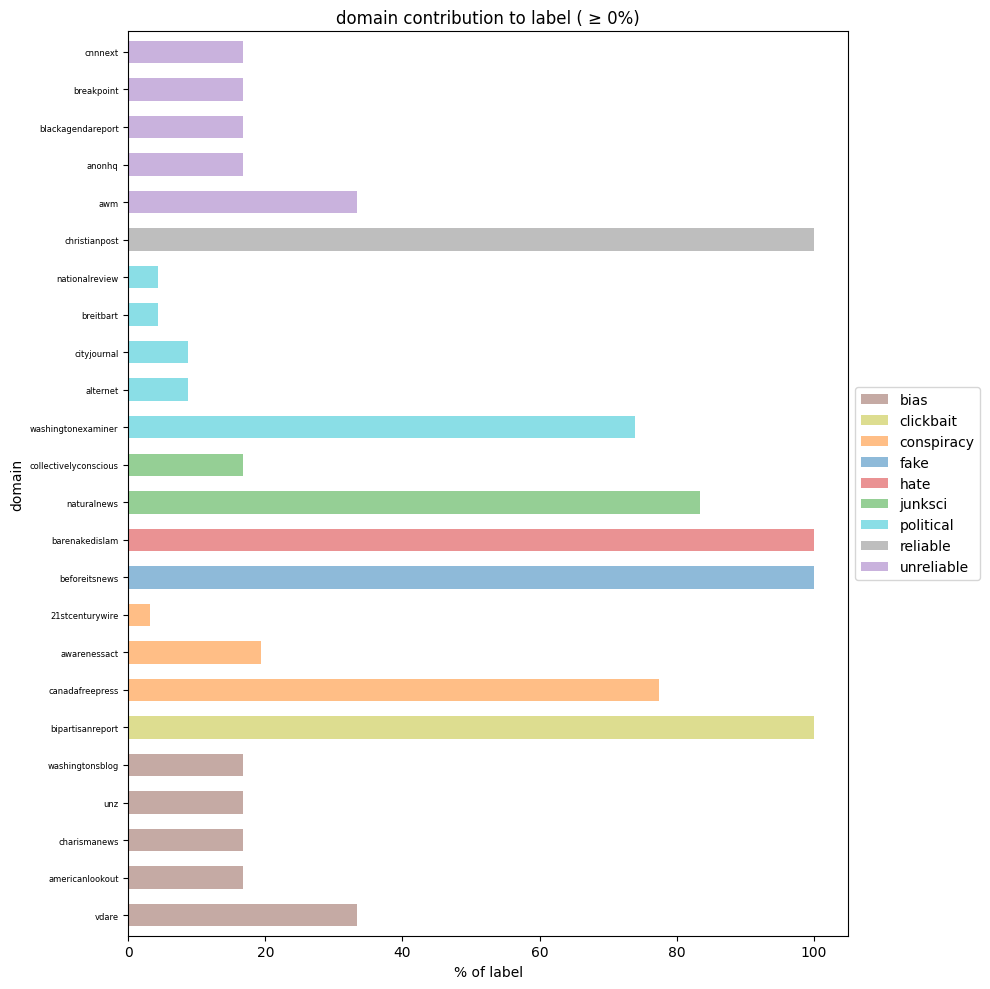

In [335]:
threshold=0
percentage=True
if not liar_set:
    Stat.barplot_x_to_y_contribution(threshold=threshold, percentage=percentage, x_label='domain', y_label='type', content_label='content_cleaned', title=f'domain contribution to label ( ≥ {threshold}%)' if percentage else f'domain contribution to label ( {threshold} most frequent)')

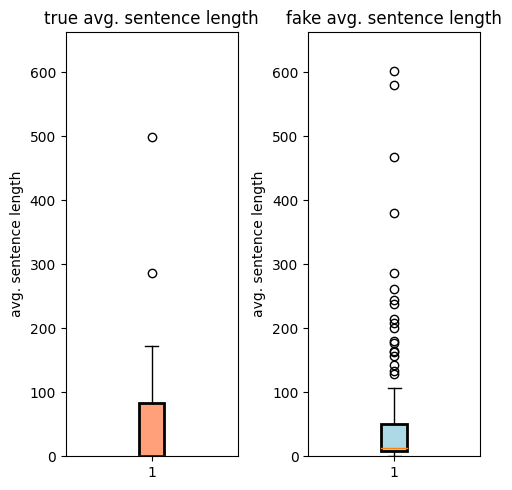

In [336]:
Stat.plot_average_sentence_length_fake_vs_true()

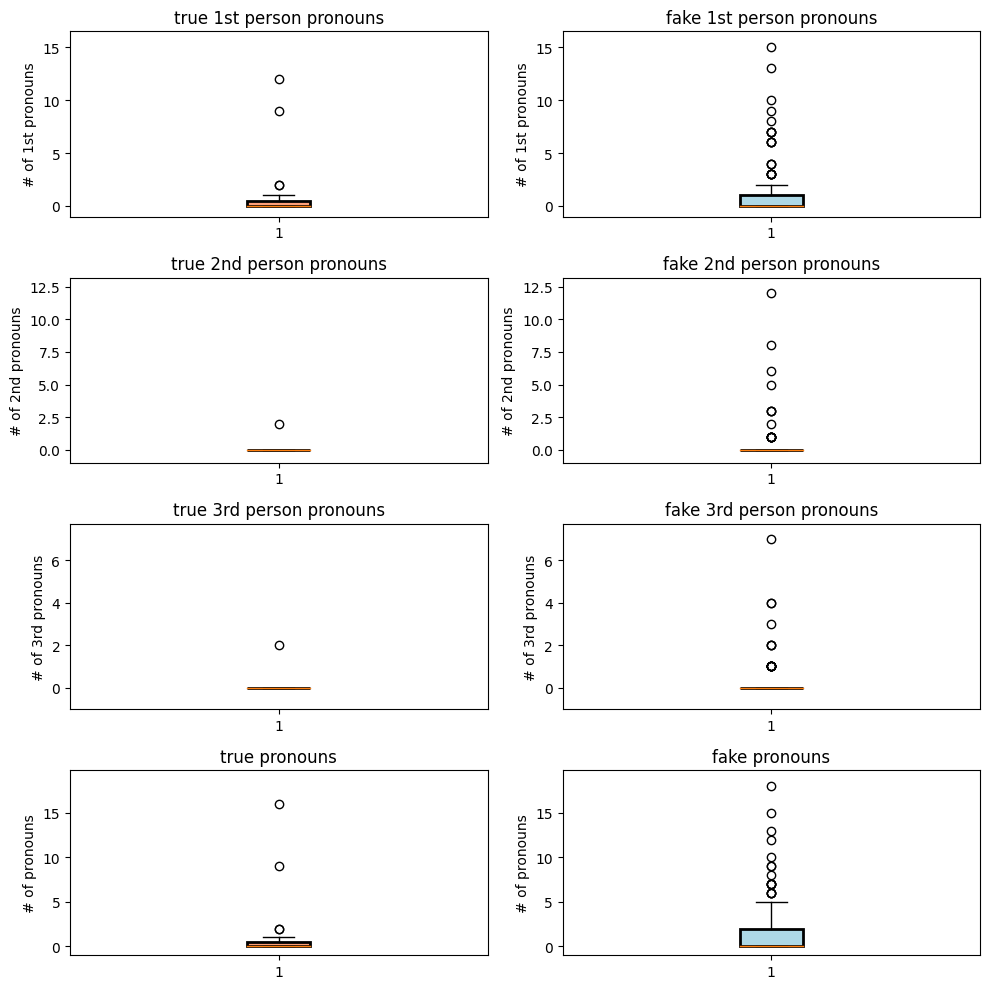

In [337]:
Stat.plot_pronouns_fake_vs_true()

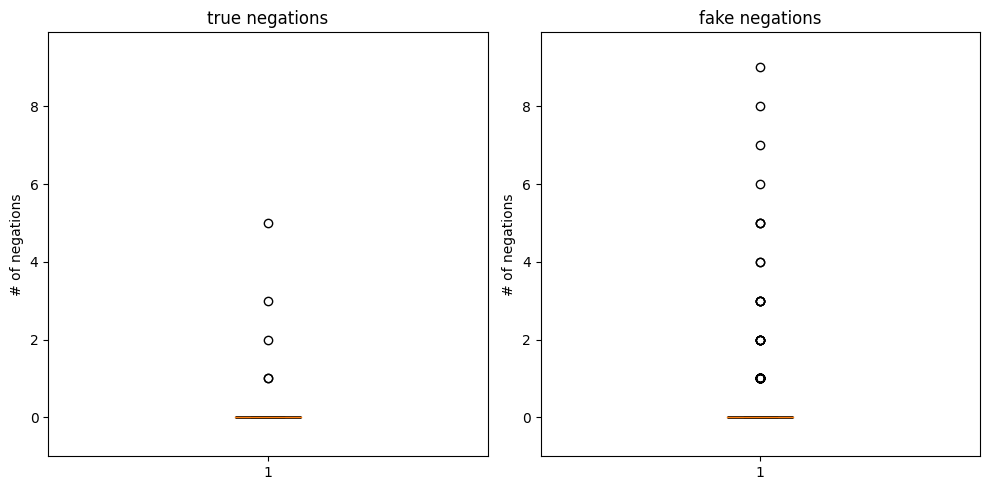

In [338]:
Stat.plot_negations_fake_vs_true()

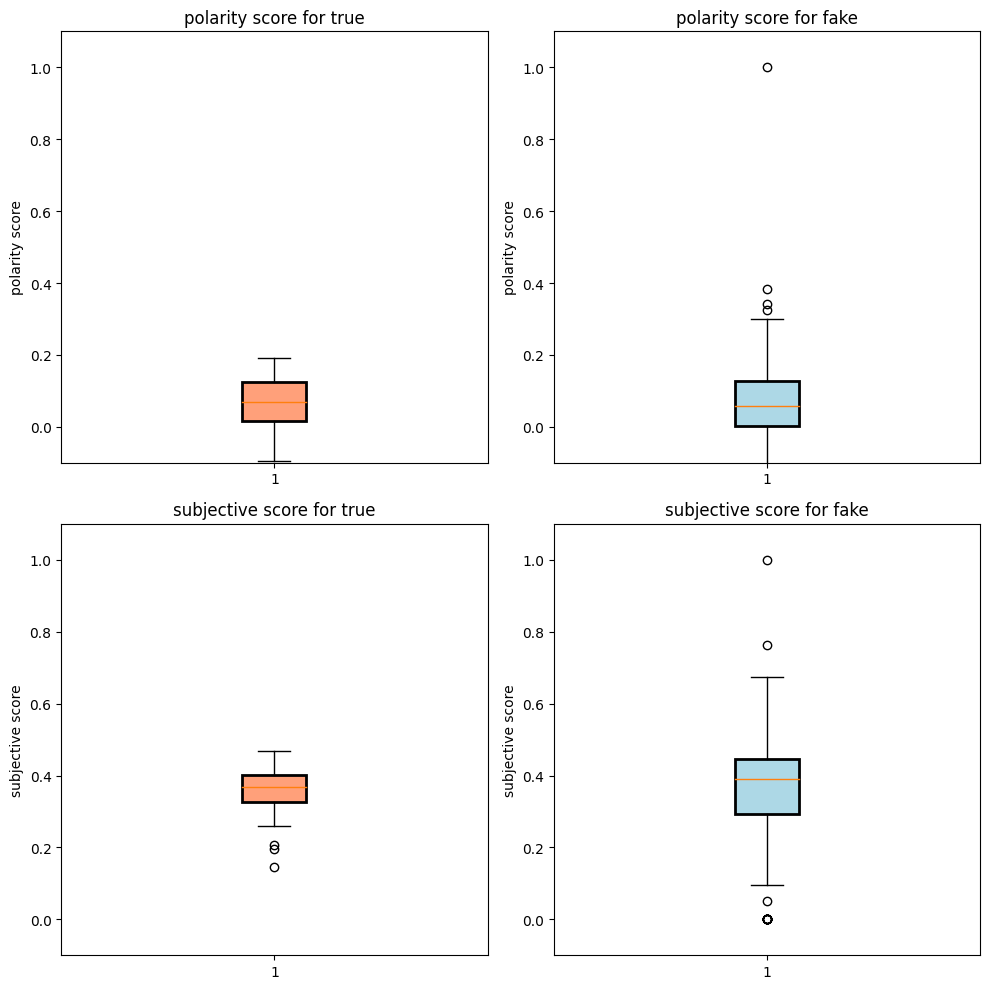

In [339]:
Stat.plot_sentence_analysis_fake_vs_true()

In [340]:
if liar_set:
    Stat.plot_party_fake_vs_true()
    Stat.plot_speaker_fake_vs_true()
    Stat.plot_subjects_fake_vs_true()

## KMeans Clustering

The KMeans clustering algorithm uses the TF-IDF (Term Frequency-Inverse Document Frequency) matrix as input to cluster the documents into k clusters. The TF-IDF matrix represents each document as a vector of term frequencies, normalized by their inverse document frequency across the corpus.

The KMeans algorithm then iteratively assigns each document to a cluster and updates the cluster centroids until convergence. The assignment is based on the similarity between the document vector and the centroid of each cluster. The similarity metric used is the Euclidean distance between the document vector and the centroid vector in the TF-IDF space.

In addition to the TF-IDF matrix, the KMeans algorithm takes several parameters, including the number of clusters (k), the initialization method (e.g., k-means++), the maximum number of iterations, and the number of times the algorithm will be run with different random initializations.

In [341]:
# Vectorize the corpus using TF-IDF
# Convert non-string values to string
content_cleaned_str = data['content_cleaned'].apply(lambda x: str(x))
# Vectorize the corpus using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(content_cleaned_str)

### Plot the elbow curve to determine the optimal number of clusters.

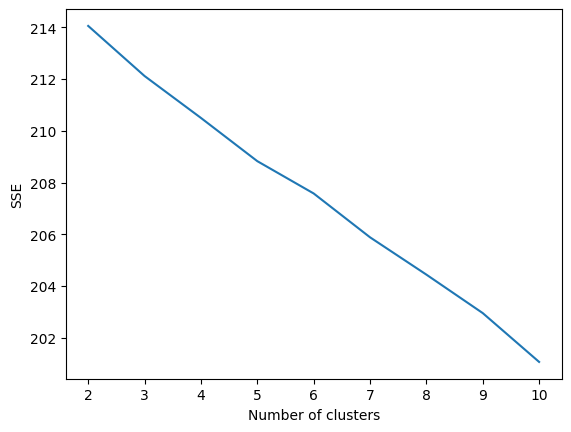

In [342]:
# Calculate SSE for different values of k
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=10).fit(tfidf)
    sse[k] = kmeans.inertia_ 

# Plot SSE against k
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

### Perform clustering using the result from the elbow curve.

In [343]:
# Perform K-Means clustering
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=10)
kmeans.fit(tfidf)

# Print the top terms in each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {i} terms: ", end='')
    for j in order_centroids[i, :10]:
        print(f"{terms[j]}, ", end='')
    print()

Top terms per cluster:
Cluster 0 terms: blockchain, url, bitcoin, sourc, stori, cent, reader, stock, headlin, exceed, 
Cluster 1 terms: num, peopl, url, like, date, govern, feel, obama, state, mani, 
Cluster 2 terms: day, christ, lord, easili, understand, differ, end, time, flagship, flagshipgav, 
Cluster 3 terms: clinton, trump, presid, error, num, date, releas, donald, investig, fbi, 
Cluster 4 terms: food, health, magnesium, dairi, cell, anxieti, url, free, medicin, ferment, 
Cluster 5 terms: market, num, date, bank, url, global, industri, gold, rate, price, 


In [344]:
# Calculate silhouette score
silhouette_avg = silhouette_score(tfidf.toarray(), kmeans.labels_, metric='euclidean', n_jobs=-1)

# Print silhouette score
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.04414993717723537


### Plot the clusters using a a scatterplot in 2d with PCA.

C:\Users\henri\AppData\Local\Temp\ipykernel_10140\3790092383.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tfidf_2d[:, 0], tfidf_2d[:, 1],


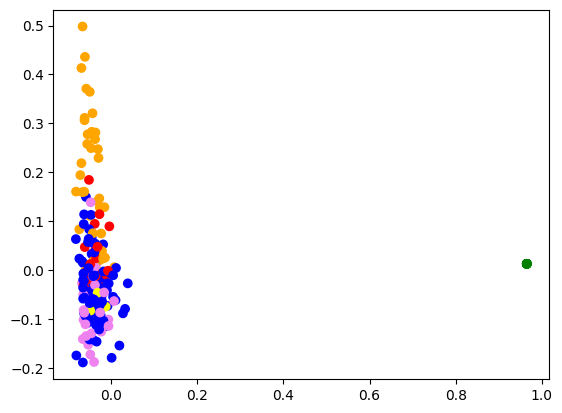

In [345]:
# Reduce the dimensions of the data using PCA
pca = PCA(n_components=2)
tfidf_2d = pca.fit_transform(tfidf.toarray())

label_to_color = {0: 'red', 1: 'blue', 2: 'green', 3: 'violet', 4: "yellow", 5: "orange"}
colors = [label_to_color[label] for label in kmeans.labels_]

# Visualize the clusters
plt.scatter(tfidf_2d[:, 0], tfidf_2d[:, 1], 
            c=colors, 
            cmap='rainbow',
            )
plt.show()

In [346]:
kmeans.labels_

array([1, 2, 5, 1, 1, 3, 5, 4, 1, 1, 0, 5, 1, 3, 1, 1, 1, 3, 1, 5, 4, 5,
       1, 1, 1, 3, 5, 5, 1, 1, 1, 5, 1, 1, 5, 1, 1, 1, 2, 3, 3, 1, 2, 0,
       1, 5, 1, 4, 1, 1, 2, 5, 1, 0, 3, 5, 1, 0, 0, 5, 5, 1, 1, 1, 1, 5,
       1, 5, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 5, 0, 1, 1, 1, 4, 1, 1, 1,
       0, 1, 5, 1, 5, 1, 2, 3, 4, 1, 1, 1, 5, 5, 0, 0, 0, 3, 1, 3, 0, 1,
       1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 5, 5, 1, 1, 0, 1, 5, 1, 3, 3, 2, 0,
       1, 0, 5, 1, 1, 1, 3, 0, 1, 1, 5, 1, 5, 1, 5, 1, 1, 1, 0, 5, 3, 5,
       3, 0, 1, 3, 0, 1, 1, 1, 5, 1, 1, 1, 3, 0, 1, 1, 2, 3, 5, 1, 5, 1,
       3, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 0, 3, 2, 1, 5, 1, 0, 1, 4, 1,
       1, 5, 1, 4, 1, 1, 1, 3, 3, 3, 1, 1, 4, 1, 3, 1, 0, 1, 3, 5, 0, 3,
       3, 1, 1, 1, 5, 0, 0, 5, 5, 1, 0, 1])

In [347]:
label_to_color = {0: 'red', 1: 'blue', 2: 'green', 3: 'violet', 4: "yellow", 5: "orange"}

In [348]:
# Print the top terms in each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1] # sort the centroids by their distance to the origin
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {label_to_color[i]} terms: ", end='')
    for j in order_centroids[i, :10]:
        print(f"{terms[j]}, ", end='')
    print()

Top terms per cluster:
Cluster red terms: blockchain, url, bitcoin, sourc, stori, cent, reader, stock, headlin, exceed, 
Cluster blue terms: num, peopl, url, like, date, govern, feel, obama, state, mani, 
Cluster green terms: day, christ, lord, easili, understand, differ, end, time, flagship, flagshipgav, 
Cluster violet terms: clinton, trump, presid, error, num, date, releas, donald, investig, fbi, 
Cluster yellow terms: food, health, magnesium, dairi, cell, anxieti, url, free, medicin, ferment, 
Cluster orange terms: market, num, date, bank, url, global, industri, gold, rate, price, 


In [349]:
# add the list with the cluster labels to the dataframe
# modify the cluster label to be a string with the color of the cluster plus the word cluster in front
data['cluster'] = kmeans.labels_
# add the cluster label to the content

# concat the cluster label to the content

# create a new column 'cluster_color' that maps cluster labels to color codes
data['cluster_color'] = data['cluster'].map(label_to_color)

# create a new column 'cluster_string' that concatenates the color code and cluster label string
data['cluster_string'] = data['cluster_color'] + 'Cluster'

data['content_with_cluster'] = data['content'] + ' ' + data['cluster_string'].astype(str)

data['content'] = data['content'].apply(lambda x: x + " " + str(kmeans.labels_))

In [350]:

cluster_top_terms = {}

for i in range(num_clusters):
    print(f"Cluster {label_to_color[i]} terms: ", end='')
    for j in order_centroids[i, :10]:
        print(f"{terms[j]}, ", end='')
        # build a dict with the top 10 terms for each cluster
        cluster_top_terms[i] = [terms[j] for j in order_centroids[i, :10]]
    print()

for cluster_label in cluster_top_terms.keys():
    # get the rows corresponding to the current cluster label
    cluster_rows = data[data['cluster'] == cluster_label]
    
    # join the top terms for the current cluster as a string
    top_terms_str = ' '.join(cluster_top_terms[cluster_label])
    
    # add the top terms to the content_with_cluster column for the current cluster rows
    data.loc[cluster_rows.index, 'content_with_cluster'] += ' ' + top_terms_str

# data.to_csv('../datasets/big/dataset_unbalanced_cleaned_cluster.csv', index=False)
data.iloc[0]['content_with_cluster']


Cluster red terms: blockchain, url, bitcoin, sourc, stori, cent, reader, stock, headlin, exceed, 
Cluster blue terms: num, peopl, url, like, date, govern, feel, obama, state, mani, 
Cluster green terms: day, christ, lord, easili, understand, differ, end, time, flagship, flagshipgav, 
Cluster violet terms: clinton, trump, presid, error, num, date, releas, donald, investig, fbi, 
Cluster yellow terms: food, health, magnesium, dairi, cell, anxieti, url, free, medicin, ferment, 
Cluster orange terms: market, num, date, bank, url, global, industri, gold, rate, price, 


'During the ceremony to mark the 72nd anniversary of the Hiroshima anniversary Japan’s Prime Minister made an effort to call for world peace. According to Shinzo Abe Japan will be doing all it can to work towards eternal world peace.\r\n\r\nAs you may know, Japan has undergone two atomic bombs both dropped by the US. The first on Hiroshima and the second just a few days later in Nagasaki; the atomic bomb on Hiroshima detonated around 600 meters above the city and killed over 140,000. While it did effectively end the Second World War it was a huge price that Japan is never willing to pay again.\r\n\r\nSadly, the commemoration was overshadowed by the threat that has been posed by North Korea. Last month, the North Korean military tested two intercontinental ballistic missiles with major US cities like Chicago within the range of attack. According to the Japan Times, around 50,000 people attended the ceremony and that included representatives from 80 nations.\r\n\r\nIf any kind of nuclear

In [351]:
kmeans.labels_
data.iloc[0]['content_with_cluster']

'During the ceremony to mark the 72nd anniversary of the Hiroshima anniversary Japan’s Prime Minister made an effort to call for world peace. According to Shinzo Abe Japan will be doing all it can to work towards eternal world peace.\r\n\r\nAs you may know, Japan has undergone two atomic bombs both dropped by the US. The first on Hiroshima and the second just a few days later in Nagasaki; the atomic bomb on Hiroshima detonated around 600 meters above the city and killed over 140,000. While it did effectively end the Second World War it was a huge price that Japan is never willing to pay again.\r\n\r\nSadly, the commemoration was overshadowed by the threat that has been posed by North Korea. Last month, the North Korean military tested two intercontinental ballistic missiles with major US cities like Chicago within the range of attack. According to the Japan Times, around 50,000 people attended the ceremony and that included representatives from 80 nations.\r\n\r\nIf any kind of nuclear

In [352]:
# Print the number of documents in each cluster
for i in range(num_clusters):
    print(f"Number of documents in cluster {i}, {label_to_color[i]}: {len(np.arange(0, tfidf.shape[0])[kmeans.labels_ == i])}")

Number of documents in cluster 0, red: 26
Number of documents in cluster 1, blue: 119
Number of documents in cluster 2, green: 9
Number of documents in cluster 3, violet: 29
Number of documents in cluster 4, yellow: 9
Number of documents in cluster 5, orange: 40


In [353]:
# Print a sample of documents in each cluster
print("Sample documents in each cluster:")
for i in range(num_clusters):
    print(f"********************************************************************")
    print(f"Cluster {i} documents: ")
    cluster = np.arange(0, tfidf.shape[0])[kmeans.labels_ == i]
    sample_docs = np.random.choice(cluster, 5, replace=False)
    for doc_index in sample_docs:
        print(f"\nTitle: {data['title'].iloc[doc_index]}")
        print(f"Content: {data['content'].iloc[doc_index]}")
        print("-"*50)


Sample documents in each cluster:
********************************************************************
Cluster 0 documents: 

Title: fed seiz <num> million bitcoin alleg silk road oper
Content: Feds seize $28 million in bitcoins from alleged Silk Road operator

% of readers think this story is Fact. Add your two cents.

Headline: Bitcoin & Blockchain Searches Exceed Trump! Blockchain Stocks Are Next!

James O’Toole

CNN Money

October 26, 2013

The Bitcoin logo.

Federal officials announced the largest-ever seizure of bitcoins on Friday night, securing $28 million worth of the digital currency from the alleged owner of the online drug marketplace Silk Road.

Bitcoin, which allows users to conduct online transactions while obscuring their identities, was the only currency accepted on Silk Road. Law enforcement officials arrested the site’s alleged proprietor, Ross Ulbricht, earlier this month, and have shuttered the operation.

Ulbricht faces a potentially lengthy prison sentence for ch

## Outliers

In [354]:
# Compute the distance between each point and its centroid
distances = np.sqrt(((tfidf.toarray() - kmeans.cluster_centers_[kmeans.labels_])**2).sum(axis=1))

In [355]:
data['distance'] = distances

for i in range(kmeans.n_clusters):
    cluster_df = data[data['cluster'] == i]
    outliers = cluster_df.nlargest(5, 'distance')
    print(f"Top 10 outliers in cluster {i}:")
    # if i ==2 :
    print(outliers['distance'])

Top 10 outliers in cluster 0:
58     0.991992
133    0.979076
218    0.978607
80     0.971849
103    0.970449
Name: distance, dtype: float64
Top 10 outliers in cluster 1:
140    1.003902
30     1.003006
148    1.002881
200    1.001014
112    1.000676
Name: distance, dtype: float64
Top 10 outliers in cluster 2:
1     1.241267e-16
38    1.241267e-16
42    1.241267e-16
50    1.241267e-16
94    1.241267e-16
Name: distance, dtype: float64
Top 10 outliers in cluster 3:
220    1.003914
39     0.985849
154    0.985728
187    0.983501
171    0.983050
Name: distance, dtype: float64
Top 10 outliers in cluster 4:
74     0.968111
210    0.958149
84     0.948608
47     0.941946
196    0.914987
Name: distance, dtype: float64
Top 10 outliers in cluster 5:
59     0.997644
134    0.996608
199    0.995670
227    0.991249
224    0.990536
Name: distance, dtype: float64


In [356]:
# Identify the outliers as points that are farthest away from their centroid
outliers = np.argsort(distances)[::-1][:30]  # top 10 outliers
print('Outliers:', outliers)

Outliers: [220 140  30 148 200 112  37  62 195  59  24  82 134 199 118 191 125 169
  71 106  58 229 123 227 224 181  16  73 223   9]


In [357]:
for idx in outliers:
    print(f"\nOutlier {idx}:")
    print(f"Domain: {data['domain'][idx]}")
    print(f"Title: {data['title'][idx]}")
    print(f"Content: {data['content'][idx]}")


Outlier 220:
Domain: collectivelyconscious
Title: stori everyth carl sagan cosmolog evolut scienc video
Content: Excerpts from Carl Sagan’s Cosmos. More specifically, from the episode titled Who Speaks For Earth. [1 2 5 1 1 3 5 4 1 1 0 5 1 3 1 1 1 3 1 5 4 5 1 1 1 3 5 5 1 1 1 5 1 1 5 1 1
 1 2 3 3 1 2 0 1 5 1 4 1 1 2 5 1 0 3 5 1 0 0 5 5 1 1 1 1 5 1 5 1 1 1 1 1 1
 4 1 1 1 1 5 0 1 1 1 4 1 1 1 0 1 5 1 5 1 2 3 4 1 1 1 5 5 0 0 0 3 1 3 0 1 1
 1 1 1 1 1 5 1 1 1 5 5 1 1 0 1 5 1 3 3 2 0 1 0 5 1 1 1 3 0 1 1 5 1 5 1 5 1
 1 1 0 5 3 5 3 0 1 3 0 1 1 1 5 1 1 1 3 0 1 1 2 3 5 1 5 1 3 3 1 1 2 1 1 1 1
 1 1 3 0 3 2 1 5 1 0 1 4 1 1 5 1 4 1 1 1 3 3 3 1 1 4 1 3 1 0 1 3 5 0 3 3 1
 1 1 5 0 0 5 5 1 0 1]

Outlier 140:
Domain: christianpost
Title: christian news christian post
Content: I wish I had done so when our now-adult daughters were teens. Two of our girls experienced sexual harassment at school. Neither were physically assaulted, but both experienced verbal sexual harassment, one by male student and one by

In [358]:
# add the cluster labels as a new column to the dataframe
data['cluster'] = kmeans.labels_

# create a list of dataframes, one for each cluster
cluster_dfs = [data[data['cluster'] == i] for i in range(kmeans.n_clusters)]

In [359]:
# print the number of data points in each cluster dataframe
for i, cluster_df in enumerate(cluster_dfs):
    print(f"Number of data points in cluster {i}, {label_to_color[i]}: {len(cluster_df)}")
    # write to csv
    cluster_df.to_csv(f"tmp/cluster_{i}.csv", index=False)

Number of data points in cluster 0, red: 26


OSError: Cannot save file into a non-existent directory: 'tmp'

## Stacked bar plot for each cluster

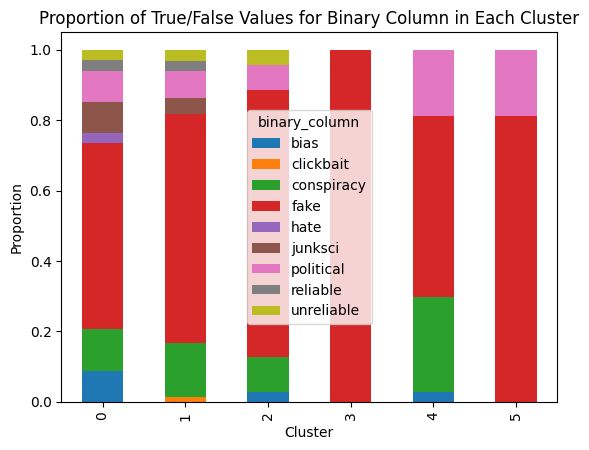

In [ ]:
# Create contingency table of true/false values for binary column in each cluster
df = pd.DataFrame({'cluster': kmeans.labels_, 'binary_column': data['type']})
contingency_table = pd.crosstab(df['cluster'], df['binary_column'], normalize='index')

# Plot stacked bar chart
contingency_table.plot(kind='bar', stacked=True)
plt.title('Proportion of True/False Values for Binary Column in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.show()

In [ ]:
# Calculate distances from each data point to its nearest centroid
distances = np.min(cdist(tfidf.toarray(), kmeans.cluster_centers_, 'euclidean'), axis=1)

# Calculate the interquartile range and the upper and lower bounds for outlier detection
q1, q3 = np.percentile(distances, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 10.5 * iqr
upper_bound = q3 + 10.5 * iqr

# Identify the outliers
outliers = np.where((distances < lower_bound) | (distances > upper_bound))[0]

# Print the number of outliers and their indices
print(f"Number of outliers: {len(outliers)}")
print("Outlier indices: ", outliers)

# Print the content of the outlier articles
for idx in outliers:
    print(f"\nOutlier {idx}:\n{data['content'][idx]}")


Number of outliers: 9
Outlier indices:  [  1  38  42  50  94 130 170 180 190]

Outlier 1:
How To Easily Understand The Difference Between The Day Of Christ And The Day Of Lord In The End Times [0 3 2 4 1 0 2 0 4 2 2 2 2 4 1 2 4 0 4 2 1 2 1 1 1 5 2 2 1 1 1 2 1 0 2 4 4
 0 3 1 4 1 3 2 4 2 2 1 1 1 3 1 1 2 0 2 1 0 1 2 2 4 1 2 1 2 1 2 1 1 4 1 2 4
 2 4 2 1 2 2 0 2 0 1 1 1 1 1 4 5 1 0 2 1 3 5 1 5 1 2 2 2 0 5 5 2 0 4 2 1 1
 4 1 0 0 0 1 4 1 5 2 2 5 1 5 1 2 2 0 4 3 5 0 0 4 4 1 4 4 0 1 1 2 2 2 1 2 1
 4 1 5 2 1 2 2 2 4 0 1 4 1 4 2 1 1 1 0 5 1 1 3 1 4 2 2 4 1 4 2 2 3 1 4 5 4
 1 2 2 2 0 3 0 2 1 2 1 1 1 2 2 0 0 0 4 2 4 4 4 4 0 1 0 5 1 2 2 0 2 2 4 0 5
 0 0 2 5 2 2 2 2 2 0]

Outlier 38:
How To Easily Understand The Difference Between The Day Of Christ And The Day Of Lord In The End Times [0 3 2 4 1 0 2 0 4 2 2 2 2 4 1 2 4 0 4 2 1 2 1 1 1 5 2 2 1 1 1 2 1 0 2 4 4
 0 3 1 4 1 3 2 4 2 2 1 1 1 3 1 1 2 0 2 1 0 1 2 2 4 1 2 1 2 1 2 1 1 4 1 2 4
 2 4 2 1 2 2 0 2 0 1 1 1 1 1 4 5 1 0 2 1 3 5 1 5 1 2 2 2 0 5 5 2 0 4 